In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

#Exercise
- Discrete Data + Probability
    - Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.




**Acquire**

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


**Parse Datetime**

In [5]:
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

**Cleanup Text**

In [6]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


**Add Variable - Converting bytes to mb**

In [7]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [8]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


**Finding anomalies in already existing data**

In [9]:
request_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request', 'request_method': 'request_count'})
request_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request', 'request_method': 'request_proba'})
request_df = request_df.merge(request_df2)


# see those where rate < 1% 
request_df[request_df.request_proba < .01]

,request,request_count,request_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/itemsitems HTTP/1.1,3,0.000215
11,GET /api/v1/sales/ HTTP/1.1,3,0.000215
12,GET /api/v1/sales/HTTP/1.1,3,0.000215


22
                                         request  request_count  request_proba
12                    GET /api/v1/sales/HTTP/1.1              3       0.000215
13                    GET /api/v1/store HTTP/1.1              3       0.000215
14                     GET /api/v1items HTTP/1.1              2       0.000143
15  GET /api/v1//api/v1/items/next_page HTTP/1.1              1       0.000072
16        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1       0.000072
17                    GET /api/v1/items/HTTP/1.1              1       0.000072
18                  GET /api/V1/HiZach! HTTP/1.1              1       0.000072
19              GET /api/v1/helloclass! HTTP/1.1              1       0.000072
20             GET /api/v1/items&page=0 HTTP/1.1              1       0.000072
21                          GET /api/v1 HTTP/1.1              1       0.000072


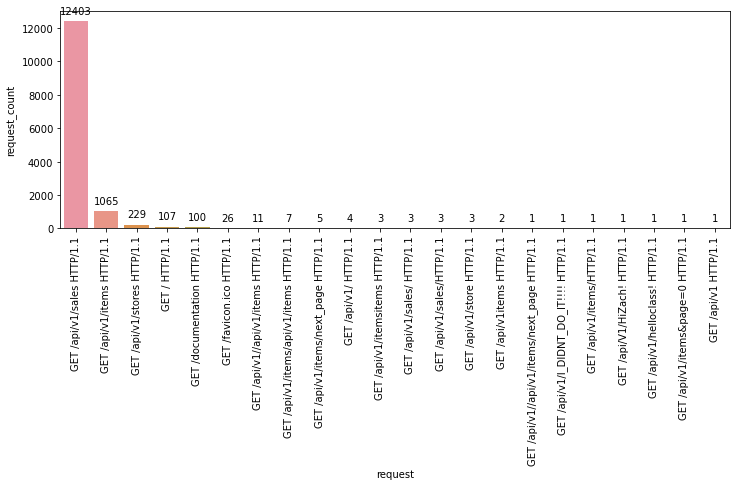

In [10]:
print(len(request_df))

print(request_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=request_df, x = 'request', y = 'request_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

**Detecting anomalies by establishing a baseline and evaluate as new data arrives.**

**Establish Baseline**

In [12]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

**Compute probabilities based on train sample**

In [22]:
request_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_proba'})

In [23]:
request_df.head()

,request_method,request_proba
0,GET /api/v1/sales HTTP/1.1,0.887577
1,GET /api/v1/items HTTP/1.1,0.076213
2,GET /api/v1/stores HTTP/1.1,0.016388
3,GET / HTTP/1.1,0.007657
4,GET /documentation HTTP/1.1,0.007156


**Merge probabilities with all data (train + new data)**

- Where the request_method is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [24]:
df = df.reset_index().merge(request_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.request_proba.value_counts()

0.887577    12403
0.076213     1065
0.016388      229
0.007657      107
0.007156      100
0.001861       26
0.000787       11
0.000215        9
0.000501        7
0.000072        6
0.000358        5
0.000286        4
0.000000        4
0.000143        2
Name: request_proba, dtype: int64

**Conditional Probabilities: Probabilities using 2 discrete variables**

**Probability of Status given Request Method**

- If we are looking for an unexpected methods from a known/common request methods.

In [27]:
request_probs = train.groupby('request_method').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['request_method', 'status']).\
                               size().div(len(train)).\
                               div(request_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_request'})
                              )

In [28]:
request_status_count = pd.DataFrame(train.groupby(['request_method', 'status'])['ip'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'ip': 'request_status_count'}))


request_status = status_given_ip.merge(request_status_count)


**Add these probabilities to original events to detect anomalous events**

In [29]:
df = df.reset_index().merge(request_status, on=['request_method', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [30]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,request_proba,proba_status_given_request,request_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.887577,0.999318,12391.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996529,1061.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.887577,0.999318,12391.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.887577,0.999318,12391.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.887577,0.999318,12391.0


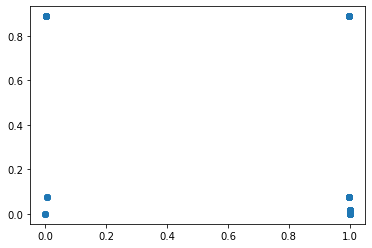

In [31]:
plt.scatter(df.proba_status_given_request, df.request_proba)